In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline

### Data Reading

car dataset size 8792
nocar dataset size 8968


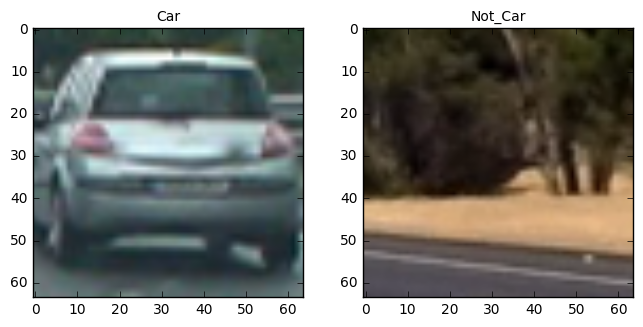

In [2]:
# Reading all the vehicle and non vehicle images
car_file = glob.glob('./vehicles/*/*.png')
nocar_file  = glob.glob('./non-vehicles/*/*.png')

cars=[]
notcars = []

for image in car_file:
    cars.append(image)

for image in nocar_file:
    notcars.append(image)

print("car dataset size %d" %len(cars))
print("nocar dataset size %d" %len(notcars))


# Plot result
from random import randint

f2, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6))
f2.tight_layout()
ax1.imshow(mpimg.imread(cars[randint(0,500)]))
ax1.set_title('Car', fontsize=10)
ax2.imshow(mpimg.imread(notcars[randint(0,500)]))
ax2.set_title('Not_Car', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0)

### HOG and Color combined features
- Perform a Histogram of Orientated Gradients(HOG) feature extraction on a labeled training set of iamge
- Apply a color transform and append binned color feature to HOG feature vector

In [3]:
# Define a function to return HOG features 
# Note HOG function only takes one-channel as input

from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec= False):
    if vis == True:
        features, hog_image = hog(img,
                                 orientations = orient,
                                 pixels_per_cell = (pix_per_cell, pix_per_cell),
                                 cells_per_block = (cell_per_block, cell_per_block),
                                 visualise = vis, feature_vector = feature_vec)
        return features, hog_image
    else:
        features = hog(img,
                      orientations = orient,
                      pixels_per_cell = (pix_per_cell, pix_per_cell),
                      cells_per_block = (cell_per_block, cell_per_block),
                      visualise =vis, feature_vector = feature_vec)
        return features
    

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

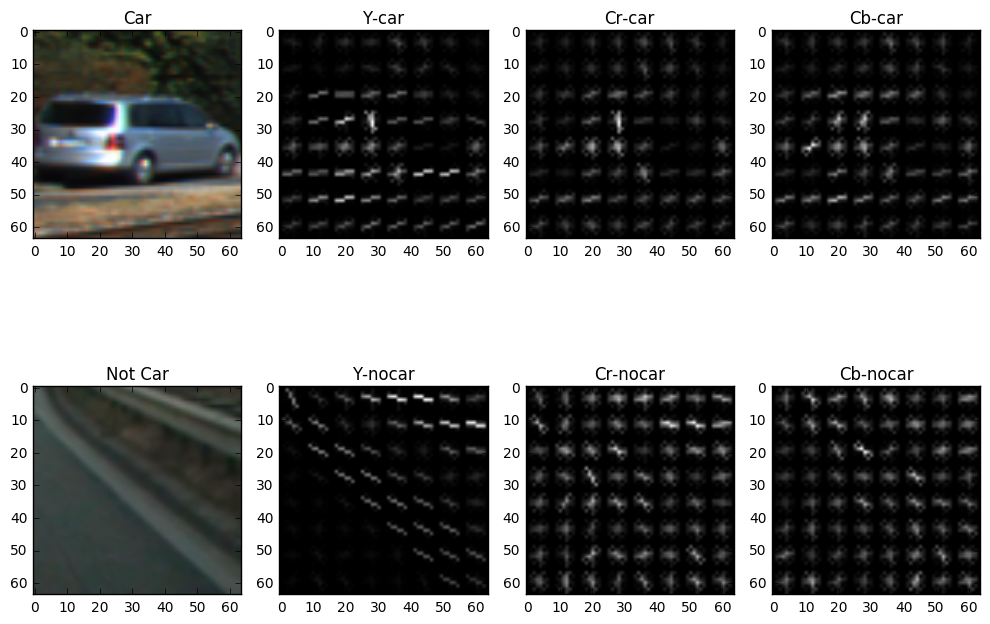

In [5]:
# Test on an example
ind = np.random.randint(0, len(cars))

img_car_original = mpimg.imread(cars[ind])
img_car = convert_color(img_car_original)

img_nocar_original = mpimg.imread(notcars[ind])
img_nocar = convert_color(img_nocar_original)

# Define HOG parameters
orient = 9
pixel_per_cell = 8
cell_per_block = 2

_, car_0 = get_hog_features(img_car[:,:,0], orient, pixel_per_cell, cell_per_block, vis=True)
_, car_1 = get_hog_features(img_car[:,:,1], orient, pixel_per_cell, cell_per_block, vis=True)
_, car_2 = get_hog_features(img_car[:,:,2], orient, pixel_per_cell, cell_per_block, vis=True)

_, nocar_0 = get_hog_features(img_nocar[:,:,0], orient, pixel_per_cell, cell_per_block, vis=True)
_, nocar_1 = get_hog_features(img_nocar[:,:,1], orient, pixel_per_cell, cell_per_block, vis=True)
_, nocar_2 = get_hog_features(img_nocar[:,:,2], orient, pixel_per_cell, cell_per_block, vis=True)

fig, axes = plt.subplots(2, 4, figsize=(10, 8))

axes[0, 0].imshow(img_car_original,cmap='gray'); axes[0, 0].set_title("Car")
axes[0, 1].imshow(car_0,cmap='gray'); axes[0, 1].set_title("Y-car")
axes[0, 2].imshow(car_1,cmap='gray'); axes[0, 2].set_title("Cr-car")
axes[0, 3].imshow(car_2,cmap='gray'); axes[0, 3].set_title("Cb-car")

axes[1, 0].imshow(img_nocar_original,cmap='gray'); axes[1, 0].set_title("Not Car")
axes[1, 1].imshow(nocar_0,cmap='gray'); axes[1, 1].set_title("Y-nocar")
axes[1, 2].imshow(nocar_1,cmap='gray'); axes[1, 2].set_title("Cr-nocar")
axes[1, 3].imshow(nocar_2,cmap='gray'); axes[1, 3].set_title("Cb-nocar")
fig.tight_layout()
plt.show()

In [6]:
# Define a function for a Color Classify

def bin_spatial(img, size=(32,32)):
    features = cv2.resize(img, size).ravel()
    return features

# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [7]:
# Combine a color and HOG classify together
# Input: an image list

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [8]:
# Combine a color and HOG classify together
# Input:  a single image

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Traning Classifier
- Normalize features and randomize a selection for training and testing
- Train a classifier Linear SVM classifer

In [9]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Parameters 

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 20    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [350, 650] # Min and max in y direction

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Training sample:', X_train.shape)
print('Test sample:', X_train.shape)

# Use a linear SVC model
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Training sample: (14208, 8424)
Test sample: (14208, 8424)
28.78 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9941


### Sliding windows search

In [10]:

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [11]:
# Draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale):
    
    draw_img = np.copy(img)
    bboxes = [] # get the boxes
    img = img.astype(np.float32)/255 #test on jpg to [0:1]
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step #start position of x
            xpos = xb*cells_per_step #start positon of y
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            combined_features = np.hstack((spatial_features, hist_features, hog_features))

            # Scale features and make a prediction
            test_features = X_scaler.transform(combined_features.reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bboxes 

In [13]:
from scipy.ndimage.measurements import label

def add_heat(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0])
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap


def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [14]:
# Vehicle Detection Pipeline

def initial_pipeline(img, ystart=360, ystop= 650, scale=1.5):    
    
    out_img, box_list = find_cars(img, ystart, ystop, scale)
    
    heat = add_heat(img, box_list)

    heat = apply_threshold(heat, 1.5)
    heatmap = np.clip(heat, 0, 255)


    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return out_img, heatmap, draw_img

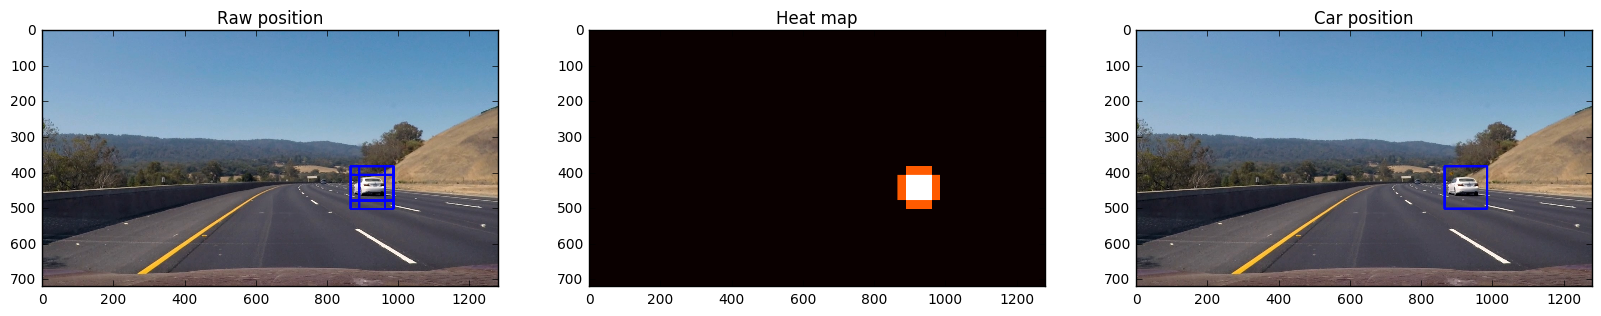

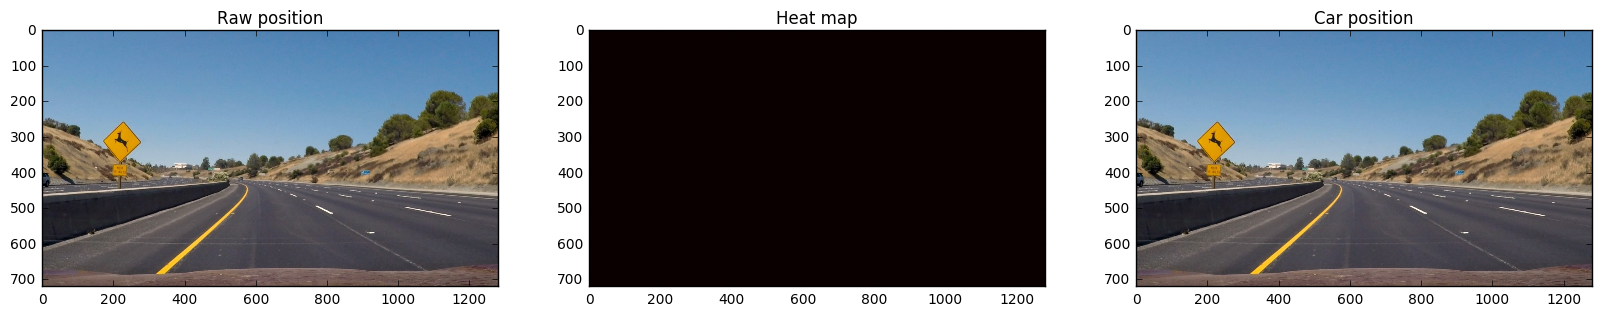

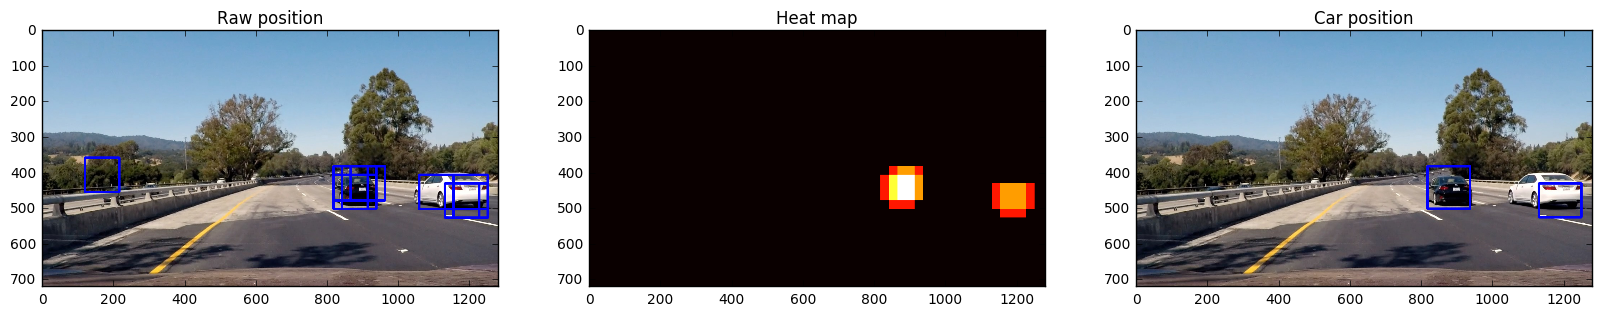

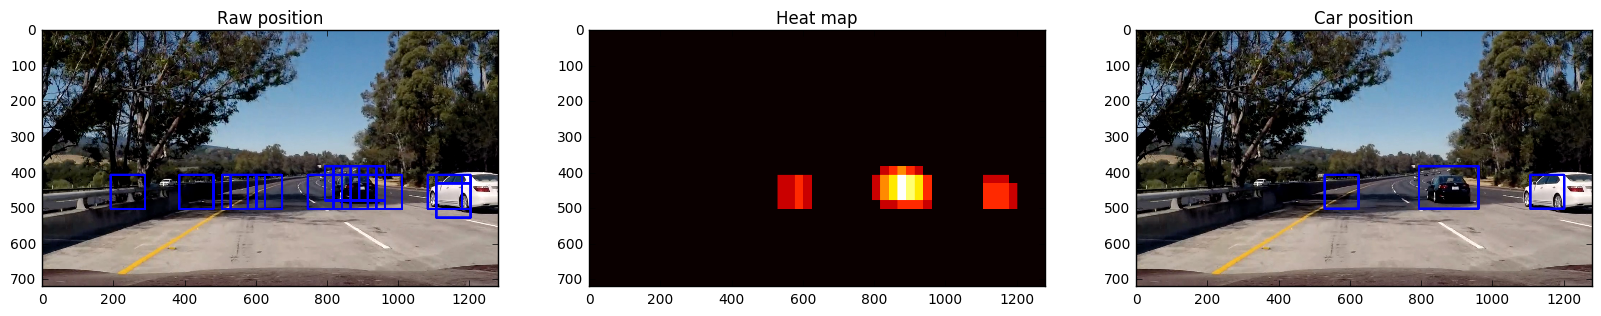

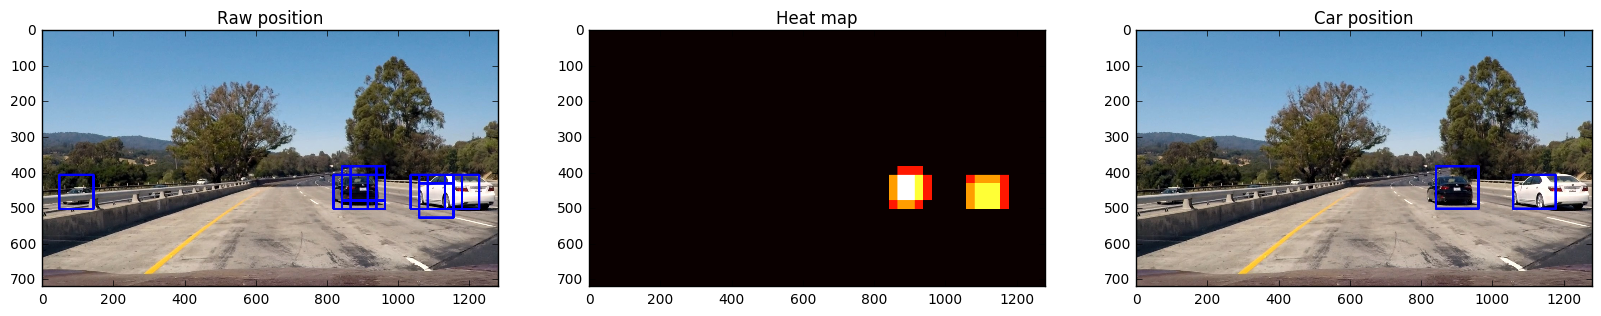

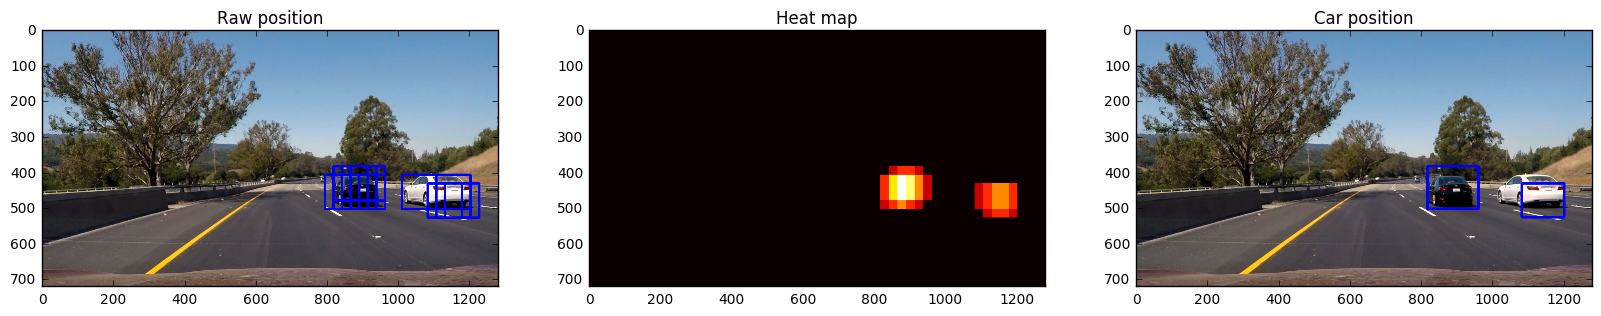

In [15]:
test_files = glob.glob('./test_images/*.jpg')

for file in test_files:
    img = mpimg.imread(file)
    
    out_img, heatmap, draw_img =initial_pipeline(img)

    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize =(20,10))
    ax1.imshow(out_img)
    ax2.imshow(heatmap,cmap='hot')
    ax3.imshow(draw_img)
    ax1.set_title('Raw position')
    ax2.set_title('Heat map')
    ax3.set_title('Car position')

In [16]:
# Vehicle Detection Pipeline
# Add multiscale searching

def final_pipeline(img):    
    
    bboxes =[]

    # horizon area    
    _, box_list1 = find_cars(img, ystart=360, ystop=460, scale=1)
    bboxes.extend(box_list1)
    
    _, box_list2 = find_cars(img, ystart=360, ystop=560, scale=1.3)
    bboxes.extend(box_list2)
    
    _, box_list3 = find_cars(img, ystart=360, ystop=660, scale=1.6)
    bboxes.extend(box_list3)

    out_img = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
    
    heat = add_heat(img, bboxes)
    heat = apply_threshold(heat, 2)
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return out_img, heatmap, draw_img

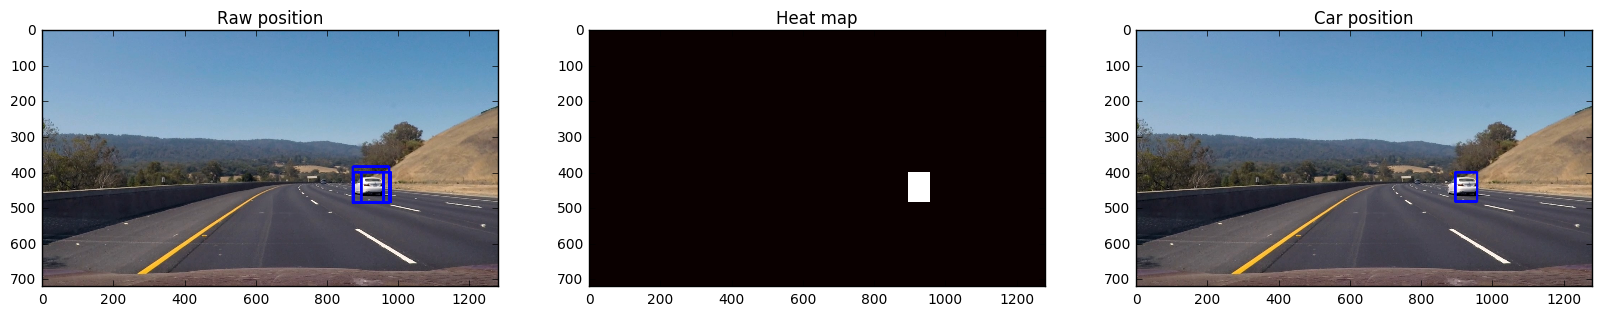

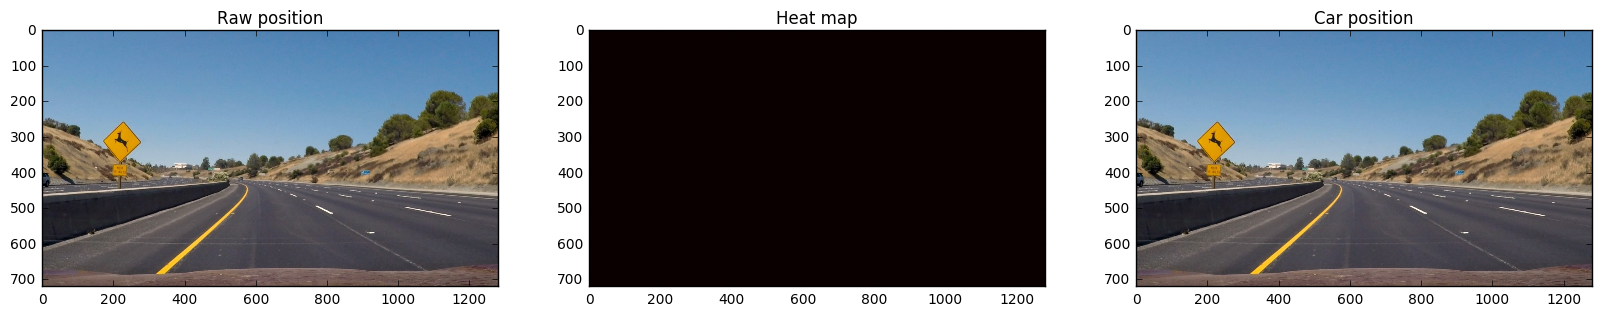

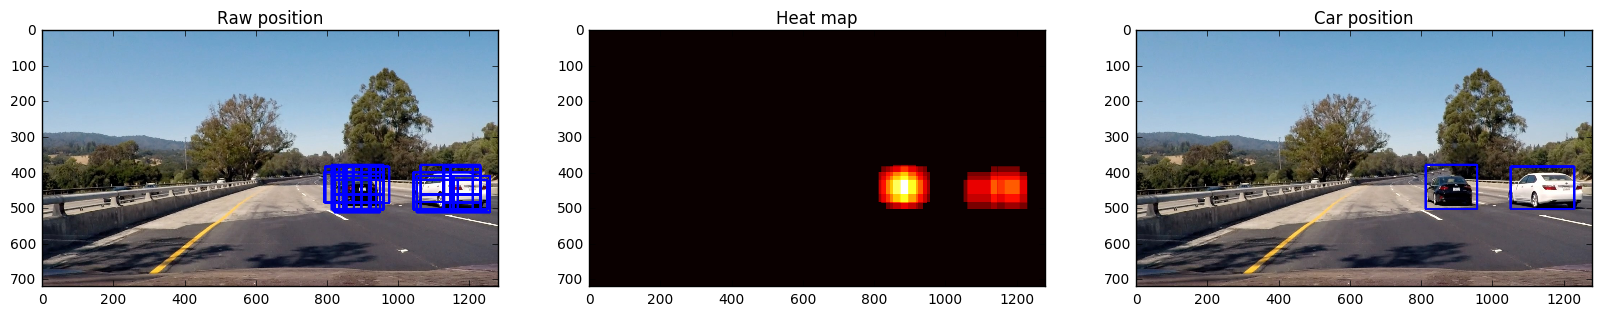

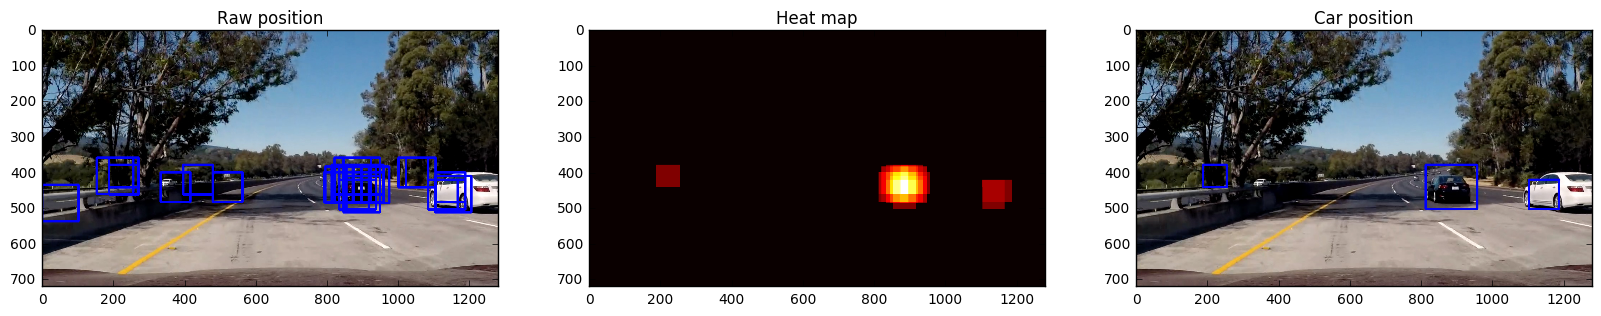

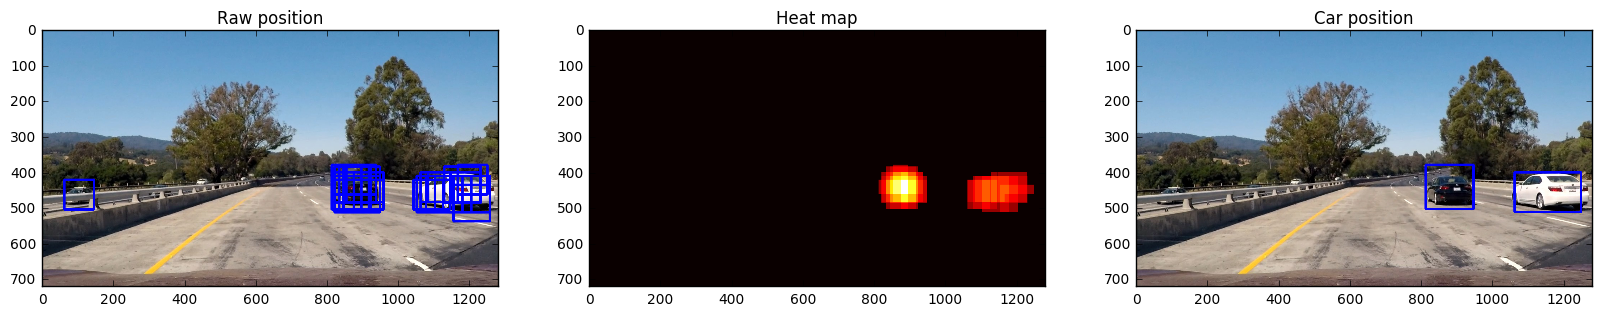

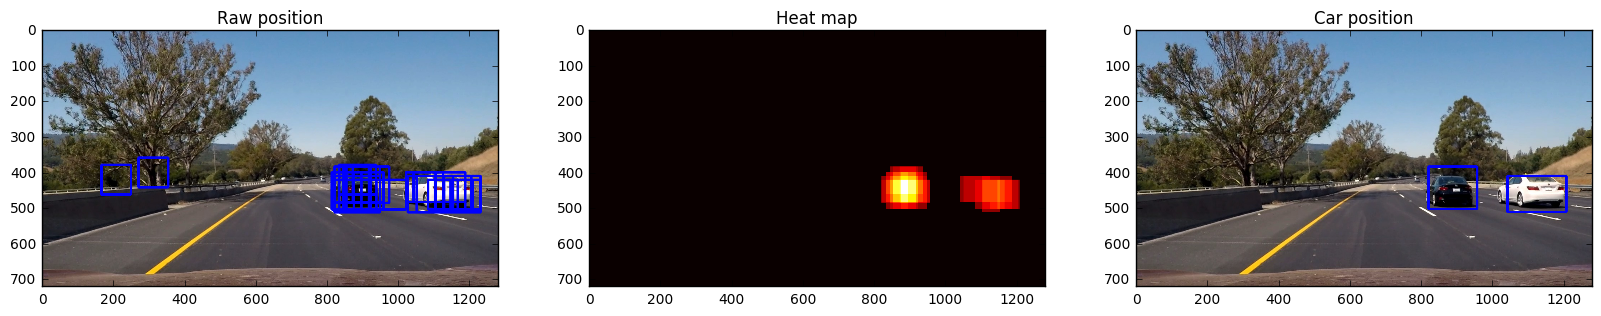

In [17]:
test_files = glob.glob('./test_images/*.jpg')

for file in test_files:
    img = mpimg.imread(file)
    
    out_img, heatmap, draw_img =final_pipeline(img)

    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize =(20,10))
    ax1.imshow(out_img)
    ax2.imshow(heatmap,cmap='hot')
    ax3.imshow(draw_img)
    ax1.set_title('Raw position')
    ax2.set_title('Heat map')
    ax3.set_title('Car position')

In [18]:
# Test on video
from moviepy.editor import VideoFileClip

video = VideoFileClip('./project_video.mp4')
new_video = video.fl_image(lambda image: final_pipeline(image)[2])
new_video.write_videofile('./result.mp4',audio=False)

[MoviePy] >>>> Building video ./result.mp4
[MoviePy] Writing video ./result.mp4


100%|█████████▉| 1260/1261 [19:09<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result.mp4 

